In [ ]:
# [Must Install before import statements]
!pip install opencv-contrib-python==3.4.2.17

import glob
import re
import cv2
import math
import random 
import statistics
import time
import sklearn
from sklearn import svm
from matplotlib import pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure
from skimage.transform import resize
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

# Please update the path below to the location for the MOT15 dataset folder
path = '/content/drive/My Drive/415FinalProjectGroup11/MOT15/'

# Please update the path below to where you want to save the generated video
video_output_path = '/content/drive/My Drive/415FinalProjectGroup11/Video/'

4/1AY0e-g4K9MIePgCAEn4-RenvlWB-UL6Af0f7YUEs8TnfXujOl5VvTZDlISYRequirement already satisfied: opencv-contrib-python==3.4.2.17 in /usr/local/lib/python3.7/dist-packages (3.4.2.17)
Mounted at /content/drive


# Dataset

In [ ]:
def draw_bounding_boxes(train_folder,human):
  ground_truth = []
  window_content = []

  if train_folder == 'TUD-Campus' and human==True:
    window_content = [[],[],[],[],[],[],[],[]]
    np.array(window_content, dtype="object")
  elif train_folder == 'TUD-Stadtmitte' and human==True:
    window_content = [[],[],[],[],[],[],[],[],[],[]]
    np.array(window_content, dtype="object")

  # read the gt.txt from the input train set
  if human==True:
    ground_truth_file = open(path+'train/'+train_folder+'/gt.txt', "r")
  else:
    ground_truth_file = open(path+'train/'+train_folder+'/gt_nonperson.txt', "r")

  for line in ground_truth_file:
      parsed_data = np.array(re.split(',', line))
      parsed_data = np.array(parsed_data[:6])
      ground_truth.append(parsed_data)
  ground_truth_file.close()

  ground_truth = np.array(ground_truth)
  ground_truth = ground_truth.astype(np.float)

  train_set_filename = []
  # populate the array with all the image filenames
  for folder in glob.glob(path+'train/'+train_folder+ '/*'):
    dataset_filename = []
    for file in sorted(glob.glob(folder + '/*.jpg')):
      dataset_filename.append(file);
    train_set_filename = np.concatenate((train_set_filename, dataset_filename), axis=None)

  labeled_train_set_img = []
  unlabeled_train_set_img = []

  # read the image and draw the bounding boxes
  for filename in train_set_filename:
    # parse the filename for drawing bounding boxes
    img_name = filename.split('/')[-1]
    frame_num = float(img_name.split('.')[0])
    
    # read the image
    image = cv2.imread(filename)
    # convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert it to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    labeled_img = image_grayscale.copy()
    copy = image_grayscale.copy()
    unlabeled_img = image_grayscale.copy()

    # draw the bounding boxes on the images based on the values given in gt.txt
    if human == True: 
      for values in ground_truth:
        if values[0] < frame_num:
          continue;
        elif values[0] == frame_num:
          # extract patches from the datasets
          # check if the person is halfway into the frame
          if values[2] < 0:
            window_content[int(values[1])-1].append(copy[int(values[3]):int(values[3]+values[5]),0:int(values[2]+values[4])])
          # check if the person is exiting the frame
          elif (values[2]+values[4]) > copy.shape[1]:
            window_content[int(values[1])-1].append(copy[int(values[3]):int(values[3]+values[5]),int(values[2]):copy.shape[1]])
          else:
            window_content[int(values[1])-1].append(copy[int(values[3]):int(values[3]+values[5]),int(values[2]):int(values[2]+values[4])])

          # create a labeled set of images for person dataset
          cv2.rectangle(labeled_img, (int(values[2]),int(values[3])), (int(values[2]+values[4]),int(values[3]+values[5])), (255, 0, 0) , 2)
          cv2.putText(labeled_img, str(int(values[1])), (int(values[2]), int(values[3]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        else:
          break;
    else:
      for values in ground_truth:
        if values[0] < frame_num:
          continue;
        elif values[0] == frame_num:
          window_content.append(copy[int(values[3]):int(values[3]+values[5]),int(values[2]):int(values[2]+values[4])])

          # create a labeled set of images for non-person dataset
          cv2.rectangle(labeled_img, (int(values[2]),int(values[3])), (int(values[2]+values[4]),int(values[3]+values[5])), (255, 0, 0) , 2)
          cv2.putText(labeled_img, str(int(values[1])), (int(values[2]), int(values[3]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        else:
          break;
          
    labeled_train_set_img.append(labeled_img)
    unlabeled_train_set_img.append(unlabeled_img)

  labeled_train_set = np.array(labeled_train_set_img)
  unlabeled_train_set = np.array(unlabeled_train_set_img)

  return labeled_train_set, window_content, unlabeled_train_set

In [ ]:
def get_img_files(folder_name,is_testing_set=True):
  img_files = []

  image_set_filename = []

  if is_testing_set == False:
  # populate the array with all the image filenames
    for folder in glob.glob(path+'train/'+folder_name+ '/*'):
      dataset_filename = []
      for file in sorted(glob.glob(folder + '/*.jpg')):
        dataset_filename.append(file);
      image_set_filename = np.concatenate((image_set_filename, dataset_filename), axis=None)
  else:
    for folder in glob.glob(path+'test/'+folder_name+ '/*'):
      dataset_filename = []
      for file in sorted(glob.glob(folder + '/*.jpg')):
        dataset_filename.append(file);
      image_set_filename = np.concatenate((image_set_filename, dataset_filename), axis=None)

  labeled_train_set_img = []
  unlabeled_train_set_img = []

  # read the image and draw the bounding boxes
  for filename in image_set_filename:
    # parse the filename for drawing bounding boxes
    img_name = filename.split('/')[-1]
    frame_num = float(img_name.split('.')[0])
    
    # read the image
    image = cv2.imread(filename)
    # convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert it to grayscale
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    unlabeled_img = image_grayscale.copy()
    img_files.append(unlabeled_img)

  return img_files


test = get_img_files('TUD-Crossing')
print(len(test))

201


In [ ]:
# Find bounding boxes on the two training sets, true for human and false for non-human
c_labeled_img_set, c_human_trainset, c_unlabeled_img_set = draw_bounding_boxes('TUD-Campus', True)
s_labeled_img_set, s_human_trainset, s_unlabeled_img_set = draw_bounding_boxes('TUD-Stadtmitte', True)
c_labeled_nonperson, c_nonhuman_trainset, c_unlabeled_nonperson = draw_bounding_boxes('TUD-Campus', False)
s_labeled_nonperson, s_nonhuman_trainset, c_unlabeled_nonperson = draw_bounding_boxes('TUD-Stadtmitte', False)

testing_set = get_img_files('TUD-Crossing')

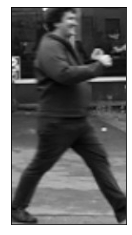

In [ ]:
# Display one human image
plt.imshow(c_human_trainset[0][0],cmap='gray')
plt.xticks([]), plt.yticks([]) 
plt.show()

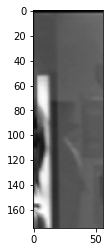

In [ ]:
# Display one non-human image
plt.imshow(s_nonhuman_trainset[0], cmap='gray')
plt.show()

In [ ]:
# Populate human and non-human sets to prepare for average image shape calculation
human = []
nonhuman = []

for id_array in c_human_trainset:
  for img in id_array:
    human.append(img)

for id_array in s_human_trainset:
  for img in id_array:
    human.append(img)

for img in c_nonhuman_trainset:
  nonhuman.append(img)

for img in s_nonhuman_trainset:
  nonhuman.append(img)

Mean of image shape: height = 174 , width = 56
Mean of aspect ratio = 0.3186245876243083


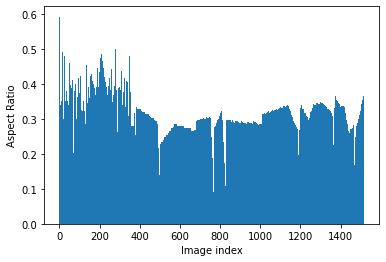

In [ ]:
# Find the average image shape to be used for resizing
height = 0
width = 0
ar = []
for img in human:
  height = height + img.shape[0]
  width = width + img.shape[1]
  ar.append(img.shape[1]/img.shape[0])

height = math.ceil(height/(len(human)))
width = math.ceil(width/(len(human)))
print("Mean of image shape: height =",height,", width =",width)
print("Mean of aspect ratio =",sum(ar)/len(ar))

# Plot histogram of the aspect ratio
x = list(range(len(ar)))
y = ar
plt.bar(x, y,width=1)
plt.xlabel('Image index')
plt.ylabel('Aspect Ratio')
plt.show()

In [ ]:
# An overview of data - to be included in the report

print("Length of c_human_trainset =",len(c_human_trainset))
print("Number of images for different labels in c_human_trainset:")
for subset in c_human_trainset:
  print(len(subset))
print("---------------------------")
print("Length of s_human_trainset =",len(s_human_trainset))
print("Number of images for different labels in s_human_trainset:")
for subset in s_human_trainset:
  print(len(subset))
print("Total number of human images =",len(human))

Length of c_human_trainset = 8
Number of images for different labels in c_human_trainset:
24
48
63
71
71
9
48
25
---------------------------
Length of s_human_trainset = 10
Number of images for different labels in s_human_trainset:
22
120
179
89
62
179
179
174
106
46
Total number of human images = 1515


In [ ]:
# Function that returns the resized 2D human dataset
def resize_human(input_list, shape):
  resized_2d = []
  for id_array in input_list:
    resized_id_array = []
    for img in id_array:
      img = cv2.resize(img, shape, interpolation = cv2.INTER_LINEAR)
      resized_id_array.append(img)
    resized_2d.append(resized_id_array)
  return resized_2d

# Function that returns the resized 1D non-human dataset
def resize_nonhuman(input_list, shape):
  resized = []
  for img in input_list:
      img = cv2.resize(img, shape, interpolation = cv2.INTER_LINEAR)
      resized.append(img)
  return resized

In [ ]:
# Update the content of human sets to a 2D array
human = np.concatenate((np.array(c_human_trainset, dtype="object"), np.array(s_human_trainset, dtype="object")), axis=0)

# Resized dataset including all test images and train images, human and non-human
resized_human = resize_human(human,(width, height))
resized_nonhuman = resize_nonhuman(nonhuman,(width, height))

# Populate image and label sets for classification
label_train_human = []
data_train_human = []

# both the human image and label sets are 2D 
# (id, data) - Campus human ids range from 0-7, Stadtmitte human ids range from 8-17
for id_array in resized_human:
  id_array_label = []
  id_array_data = []
  for img in id_array:
    id_array_label.append(1)
    id_array_data.append(img)
  label_train_human.append(id_array_label)
  data_train_human.append(id_array_data)

label_train_nonhuman = []
data_train_nonhuman = []

for img in resized_nonhuman:
  label_train_nonhuman.append(0)
  data_train_nonhuman.append(img)

In [ ]:
print(len(data_train_nonhuman))

67


In [ ]:
# Re-arrange the nonhuman images to be a 2D list
random.shuffle(data_train_nonhuman)
data_train=[]
label_train = []
for i in range(len(data_train_nonhuman)):
  data_train.append([])
  data_train[i].append(data_train_nonhuman[i])
  label_train.append(0)

# Join human and nonhuman
for subset in data_train_human:
  data_train.append(subset)
for subset in label_train_human:
  label_train.append(subset)
  
print(len(data_train))
print(len(label_train))

85
85


# Classification

In [ ]:
# Feature extraction
def HOG(input_list,N_orientations,pixels_per_cell,cells_per_block,scaling_factor):
  output_h = []
  output_img = []
  for i in range(len(input_list)):
    resized_img = cv2.resize(input_list[i],None,fx = scaling_factor, 
                          fy = scaling_factor, interpolation = cv2.INTER_LINEAR)
    fd, hog_image = hog(resized_img, orientations=N_orientations, 
                        pixels_per_cell = pixels_per_cell, 
          cells_per_block=cells_per_block, visualize=True, multichannel=False)
    output_h.append(fd)
    output_img.append(hog_image)
  return output_h, output_img

In [ ]:
# Function converting a 2D list to 1D
def to1D(input):
  out = []
  for subset in input:
    if subset == 0:
      out.append(0)
    else:
      for item in subset:
        out.append(item)
  return out

In [ ]:
# K-fold cross validation, 2D input lists

def kfold_crossvalid2D(trainlabels, trainimgs, clf,K=5):
  kfold = KFold(K, True, 1)
  acc = []
  pre = []
  rec = []
  for ((train, test), (train_labels, test_labels)) in zip(kfold.split(trainimgs), kfold.split(trainlabels)):
    img = []
    img1 = []
    label = []
    label1 = []
    for i in train:
      img.append(trainimgs[i])
      label.append(trainlabels[i])
    for i in test:
      img1.append(trainimgs[i])
      label1.append(trainlabels[i])
    img = to1D(img)
    img1 = to1D(img1)
    label = to1D(label)
    label1 = to1D(label1)

    h_list_train, h_img_train = HOG(img,ott,ppc,cpb,sf)
    h_list_test, h_img_test = HOG(img1,ott,ppc,cpb,sf)

    # SVM or K Nearest Neighbors
    if clf == 0:
      clf1.fit(h_list_train, label)
      label_pred = clf1.predict(h_list_test)
    else:
      clf2.fit(h_list_train, label)
      #TODO: change clf1 to clf2
      label_pred = clf1.predict(h_list_test)

    count = 0
    tp_count = 0
    fp_count = 0
    fn_count = 0
    for i in range(len(label1)):
      if label1[i] == label_pred[i]:
        count += 1
      if label1[i] == 1 and label_pred[i] == 1:
        tp_count += 1
      if label1[i] == 0 and label_pred[i] == 1:
        fp_count += 1
      if label1[i] == 1 and label_pred[i] == 0:
        fn_count += 1
    acc.append(100*count/len(label1))
    pre.append(100*tp_count/(tp_count + fp_count))
    rec.append(100*tp_count/(tp_count + fn_count))

  print("Average Accuracy: ",np.around(sum(acc)/len(acc), 2),"  Standard deviation:",np.around(statistics.pstdev(acc),2))
  print("Average Precision:",np.around(sum(pre)/len(pre), 2),"  Standard deviation:",np.around(statistics.pstdev(pre),2))
  print("Average Recall:   ",np.around(sum(rec)/len(rec), 2),"  Standard deviation:",np.around(statistics.pstdev(rec),2))

In [ ]:
# Alternative - K nearest neighbors
# clf1 and clf2 are used to validate
clf1 = svm.LinearSVC()
clf2 = KNeighborsClassifier(n_neighbors=1, p=2)

# SVM
# Choose parameters of feature extraction method
ott = 9       # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 1        # Scalling factor for image size

# Classification Validation

In [ ]:
# Alternative - K nearest neighbors
# clf1 and clf2 are used to validate
clf1 = svm.LinearSVC()
clf2 = KNeighborsClassifier(n_neighbors=1, p=2)
# Choose parameters of feature extraction method
ott = 9       # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 1        # Scalling factor for image size
kfold_crossvalid2D(label_train, data_train,0)
# KNN
print("-------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)
# Overall better performance for all metrics than SVM

Average Accuracy:  98.83   Standard deviation: 1.07
Average Precision: 99.62   Standard deviation: 0.38
Average Recall:    99.11   Standard deviation: 1.11
-------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# To be included in the report, performance of the classifier in terms of the parameters of HoG
# Test 1 - Increase number of orientations - overall better performance for all metrics than ott = 9
ott = 12      # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 1        # Scalling factor for image size
kfold_crossvalid2D(label_train, data_train,0)
print("-------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  98.95   Standard deviation: 1.02
Average Precision: 99.62   Standard deviation: 0.38
Average Recall:    99.24   Standard deviation: 1.01
-------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# Test 3 - original hyperparameters for clfs
# Decrease image size to 60% - better performance, reduced complexity
ott = 9       # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 0.6      # Scalling factor for image sizef

kfold_crossvalid2D(label_train, data_train,0)
print("---------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  99.12   Standard deviation: 0.87
Average Precision: 99.68   Standard deviation: 0.41
Average Recall:    99.36   Standard deviation: 0.8
---------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# Test 4 - Decrease image size to 30% - better, much faster
ott = 9       # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 0.3      # Scalling factor for image size

kfold_crossvalid2D(label_train, data_train,0)
print("---------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  98.94   Standard deviation: 0.83
Average Precision: 99.32   Standard deviation: 0.66
Average Recall:    99.53   Standard deviation: 0.72
---------------------------------------------------------------------------
Average Accuracy:  99.66   Standard deviation: 0.69
Average Precision: 99.62   Standard deviation: 0.77
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# Test 5 - Decrease image size to 30% and increase orientations - subtle changes depending on the data
ott = 12      # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 0.3      # Scalling factor for image size

kfold_crossvalid2D(label_train, data_train,0)
print("---------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  99.37   Standard deviation: 0.62
Average Precision: 99.56   Standard deviation: 0.33
Average Recall:    99.75   Standard deviation: 0.51
---------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# Test 6 - Decrease image size to 60% and increase orientations - subtle changes depending on the data
clf1 = svm.LinearSVC(C = 0.1)
clf2 = KNeighborsClassifier(n_neighbors=1, p=2)
ott = 12      # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 0.6      # Scalling factor for image size

kfold_crossvalid2D(label_train, data_train,0)
print("---------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  99.07   Standard deviation: 0.82
Average Precision: 99.63   Standard deviation: 0.38
Average Recall:    99.36   Standard deviation: 0.8
---------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# Test 2 - original hyperparameters for HoG, different for clfs
clf1 = svm.LinearSVC(C = 10)
clf2 = KNeighborsClassifier(n_neighbors=3, p=2)
ott = 9       # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 1        # Scalling factor for image size
kfold_crossvalid2D(label_train, data_train,0)
print("---------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  98.83   Standard deviation: 1.07
Average Precision: 99.62   Standard deviation: 0.38
Average Recall:    99.11   Standard deviation: 1.11
---------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


In [ ]:
# Test 2.1 - original hyperparameters for HoG, different for clfs
clf1 = svm.LinearSVC(C = 0.1)
clf2 = KNeighborsClassifier(n_neighbors=10, p=2)
ott = 9       # Number of orientations
ppc = (8,8)   # Pixels per cell
cpb = (2,2)   # Cells per block
sf = 1        # Scalling factor for image size
kfold_crossvalid2D(label_train, data_train,0)
print("---------------------------------------------------------------------------")
kfold_crossvalid2D(label_train, data_train,1)

Average Accuracy:  98.95   Standard deviation: 1.02
Average Precision: 99.62   Standard deviation: 0.38
Average Recall:    99.24   Standard deviation: 1.01
---------------------------------------------------------------------------
Average Accuracy:  99.83   Standard deviation: 0.34
Average Precision: 99.81   Standard deviation: 0.39
Average Recall:    100.0   Standard deviation: 0.0


# Detection and Localization

In [ ]:
#Re-construct the classifier we built in Question 4:
#label_train, data_train

clf_final = svm.LinearSVC()
train_imgs = to1D(data_train)
train_labels = to1D(label_train)
p5_list_train, p5_img_train = HOG(train_imgs,ott,ppc,cpb,sf)
clf_final.fit(p5_list_train, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
# Function for calculating the IoU
# Example:
# test = calculate_iou((399,182,399+121,182+229),(399,182,399+121,182+229))

def calculate_iou(predicted_coord, gt_coord):
  # determine the x and y coordinates of the intersection rectangle
  x_a = max(predicted_coord[0], gt_coord[0])
  y_a = max(predicted_coord[1], gt_coord[1])
  x_b = min(predicted_coord[2], gt_coord[2])
  y_b = min(predicted_coord[3], gt_coord[3])

  # calculate the intersection area (TP)
  intersection_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

  # handle non-overlapping cases
  if intersection_area < 0:
    intersection_area = 0

  # calculate the area of the prediction and area of the ground-truth
  predicted_area = (predicted_coord[2] - predicted_coord[0] + 1) * (predicted_coord[3] - predicted_coord[1] + 1)
  gt_area = (gt_coord[2] - gt_coord[0] + 1) * (gt_coord[3] - gt_coord[1] + 1)

  # calculate the iou by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
  iou = intersection_area / float(predicted_area + gt_area - intersection_area)

  return iou

In [ ]:
testing_set = get_img_files('TUD-Crossing')

# number of bounding boxes
bounding_box_num = 0

# size of the window != size of training image
# Hyperparam_1
wind_width_height = (250, 100)
# shall resize to dim to fit the classification requirement 
dim = (56, 174)

# Stores every img coordinates classified
# classified_imgs[#pic][#person][0~3]
# 0, 1, 2, 3 <==> [x, y, w, h]
classified_imgs = []

# Campus set 
unlabel_img_set = np.concatenate((np.array(c_unlabeled_img_set), np.array(s_unlabeled_img_set)), axis=0)

# Crossing data set
# unlabel_img_set = get_img_files('TUD-Crossing')

# Generate a sliding window to detect the faces in the group photo
def sliding_window_generator(input_img, step_row, step_col):
  for row_num in range(0, img.shape[0], step_row):
    for col_num in range(0, img.shape[1], step_col):
      # yield the current window at given location on the image
      yield (col_num, row_num, img[row_num: row_num + wind_width_height[0], col_num: col_num + wind_width_height[1]])

def if_intersect1(box_a_tlx, box_a_tly, box_a_w, box_a_h, box_b_tlx, box_b_tly, box_b_w, box_b_h):
  return (abs((box_a_tlx + box_a_w/2) - (box_b_tlx + box_b_w/2)) * 2 < (box_a_w + box_b_w)) and (abs((box_a_tly + box_a_h/2) - (box_b_tly + box_b_h/2)) * 2 < (box_a_h + box_b_h))

def if_intersect2(box_a_tlx, box_a_tly, box_a_w, box_a_h, box_b_tlx, box_b_tly, box_b_w, box_b_h):
    iou_result = calculate_iou((box_a_tlx,box_a_tly,box_a_tlx+box_a_w,box_a_tly+box_a_h),
                               (box_b_tlx,box_b_tly,box_b_tlx+box_b_w,box_b_tly+box_b_h))
    return iou_result > 0.1


unlabel_imgs = get_img_files('TUD-Crossing')
original_imgs = get_img_files('TUD-Crossing')


for img in unlabel_img_set:
  # final bounding boxes list stores processed bounding boxes
  final_bb = []
  for col_loc, row_loc, sliding_window in sliding_window_generator(img, 90, 100): # Hyperparam_2
    # Compare the height and width of the sliding window at its current location to make sure it does not go outside of the group photo
    if sliding_window.shape[0] == wind_width_height[0] and sliding_window.shape[1] == wind_width_height[1]:
      bounding_box_num+=1
      img2predict = img[row_loc: row_loc + wind_width_height[0], col_loc: col_loc + wind_width_height[1]]
      img2predict = cv2.resize(img2predict, dim, interpolation = cv2.INTER_AREA)
      empty = []
      empty.append(img2predict)

      img2predict_list, img2predict_test = HOG(empty,ott,ppc,cpb,sf)
      classify_result = clf_final.predict(img2predict_list)
      if(classify_result == 1):
        if not final_bb:
          final_bb.append([col_loc, row_loc, wind_width_height[1],  wind_width_height[0]])
        else:
          ifmerged = False
          for i in range(len(final_bb)):
            # (x, y, w, h)
            if if_intersect2(final_bb[i][0], final_bb[i][1], final_bb[i][2], final_bb[i][3], 
                            col_loc, row_loc, wind_width_height[1],  wind_width_height[0]):
              final_bb[i][0] = min(final_bb[i][0], col_loc)
              final_bb[i][1] = min(final_bb[i][1], row_loc)
              final_bb[i][2] = max(final_bb[i][0] + final_bb[i][2], col_loc + wind_width_height[1]) - final_bb[i][0]
              final_bb[i][3] = max(final_bb[i][1] + final_bb[i][3], row_loc + wind_width_height[0]) - final_bb[i][1]
              ifmerged = True
          if not ifmerged:
            final_bb.append([col_loc, row_loc, wind_width_height[1], wind_width_height[0]])

  # draw combined(processed) boxes
  for i in range(len(final_bb)):
    cv2.rectangle(img, (final_bb[i][0], final_bb[i][1]), 
                        (final_bb[i][0] + final_bb[i][2], final_bb[i][1] + final_bb[i][3]), 
                        (255, 0, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (5, 25)
    fontScale = 1
    color = (255, 0, 0)
    thickness = 1
    cv2.putText(img[final_bb[i][1]: final_bb[i][1] + final_bb[i][3], final_bb[i][0]: final_bb[i][0] + final_bb[i][2]],
                str(i+1), org, font, fontScale, color, thickness, cv2.LINE_AA)
    
  # Merge coordinates information to classified_imgs 
  classified_imgs.append(final_bb)

print("Number of bounding boxes: " + str(bounding_box_num))

Number of bounding boxes: 4500


IoU Mean: 0.3250013078245114
IoU Standard Deviation: 0.1624152543317621


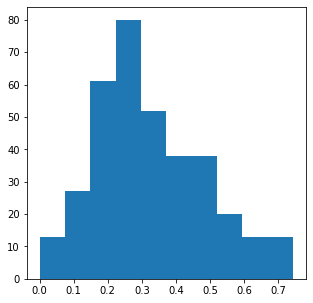

In [ ]:
# Create the ground truth array
# classified_imgs[#pic][#person][0~3]
# 0, 1, 2, 3 <==> [x, y, w, h]

def get_getloc(train_folder = 'TUD-Campus'):
  gt_coordinates = []
  ground_truth = []
  ground_truth_file = open(path+'train/'+train_folder+'/gt.txt', "r")
  for line in ground_truth_file:
    parsed_data = np.array(re.split(',', line))
    parsed_data = np.array(parsed_data[:6])
    ground_truth.append(parsed_data)
  ground_truth_file.close()
  ground_truth = np.array(ground_truth)
  ground_truth = ground_truth.astype(np.float)

  last_folder = 1
  img_coordinate = []
  for info in ground_truth:
    if not info[0] == last_folder:
      gt_coordinates.append(img_coordinate)
      #reset img_coordinate
      img_coordinate = []
      last_folder += 1
    
    img_coordinate.append([info[2], info[3], info[4], info[5]])

  return gt_coordinates

gt_coordinates = get_getloc()

IoU_distribution = []

for i in range(len(gt_coordinates)):
  #for each img
  for j in range(len(gt_coordinates[i])):
    maxiou = 0
    for k in range(len(classified_imgs[i])):
      
      iou_result = calculate_iou((gt_coordinates[i][j][0],gt_coordinates[i][j][1],
                                  gt_coordinates[i][j][0]+gt_coordinates[i][j][2],gt_coordinates[i][j][1]+gt_coordinates[i][j][3]),
                               (classified_imgs[i][k][0],classified_imgs[i][k][1],
                                classified_imgs[i][k][0]+classified_imgs[i][k][2],classified_imgs[i][k][1]+classified_imgs[i][k][3]))
      if iou_result > maxiou:
        maxiou = iou_result
    IoU_distribution.append(maxiou)

print("IoU Mean:", statistics.mean(IoU_distribution))
print("IoU Standard Deviation:", statistics.stdev(IoU_distribution))
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(IoU_distribution)
plt.show()

# Tracking

(480, 640, 2)
(480, 640)


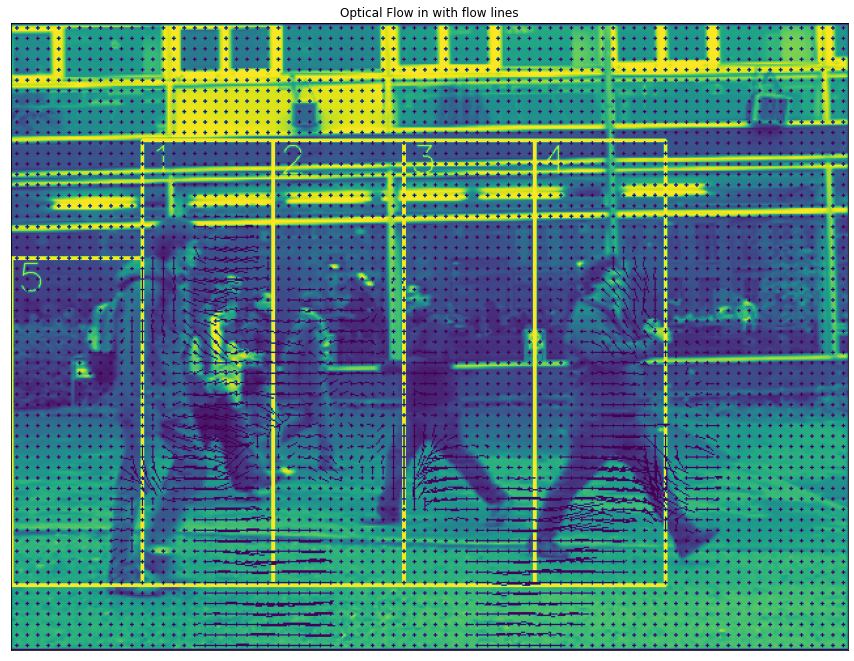

In [ ]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.2)
    vis = img.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

flow = cv2.calcOpticalFlowFarneback(prev=unlabel_img_set[3], 
                                    next=unlabel_img_set[5], 
                                    flow=None,
                                    pyr_scale=0.5, 
                                    levels=3, 
                                    winsize=15,
                                    iterations=3, 
                                    poly_n=5, 
                                    poly_sigma=1.2, 
                                    flags=0)

# draw flow
print(flow.shape)
print(unlabel_img_set[5].shape)
vis = draw_flow(unlabel_img_set[0], flow, step=8)

# display images
plt.figure(figsize=(15,15))
plt.imshow(vis)
plt.title("Optical Flow in with flow lines"), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
def cal_mean(flow, x, y, w, h):
  cum_dx = 0
  cum_dy = 0
  for i in range(x, x+w):
    for j in range(y, y+h):
      cum_dx += flow[j][i][0]
      cum_dy += flow[j][i][1]
  mean_dx = cum_dx/(480*640)
  mean_dy = cum_dy/(480*640)      
  return mean_dx, mean_dy

def positionEstimation(img_prev, img_curr, people):
  # people[0~2][0~3]
  #0, 1, 2 <==> person1, person2, person3
  # 0, 1, 2, 3 <==> [x, y, w, h]
  new_positions = []
  opticalflow = cv2.calcOpticalFlowFarneback(prev=img_prev, 
                                    next=img_curr, 
                                    flow=None,
                                    pyr_scale=0.5, 
                                    levels=3, 
                                    winsize=15,
                                    iterations=3, 
                                    poly_n=5, 
                                    poly_sigma=1.2, 
                                    flags=0)
  
  for focusedPerson in people:
    dx, dy = cal_mean(opticalflow, focusedPerson[0], focusedPerson[1], focusedPerson[2], focusedPerson[3])
    new_positions.append([focusedPerson[0] + dx, focusedPerson[1] + dy, focusedPerson[2], focusedPerson[3]])
  
  return new_positions


In [ ]:
from google.colab.patches import cv2_imshow
import time

def tracker_algo(unlabel_imgs, classified_imgs, peopleLabels):
  #people position is updated in each iteration
  plp_positions = []
  iou_records = []

  for label in peopleLabels:
    label -= 1
  
  est_positions = [classified_imgs[1][peopleLabels[0]], classified_imgs[1][peopleLabels[1]], classified_imgs[1][peopleLabels[2]]]
  label_position = [1, 2, 3]

  # hyper param set length = 70, 
  campus_range = range(1, 70)
  stad_range = range(71, len(unlabel_imgs))
  crossing_range = range(1, len(unlabel_imgs))
  
  for i in crossing_range:
    actual_position = []
    for j in range(len(est_positions)):
      if (est_positions[j][0]+est_positions[j][2] > 640 or est_positions[j][1]+est_positions[j][3] > 480):
        break

      # For each selected person
      maxIoU = 0
      bestMatchedGT = []

      for k in range(len(classified_imgs[i])):
        iou_result = calculate_iou((est_positions[j][0],est_positions[j][1],
                                    est_positions[j][0]+est_positions[j][2],est_positions[j][1]+est_positions[j][3]),
                                   (classified_imgs[i][k][0],classified_imgs[i][k][1],
                                    classified_imgs[i][k][0]+classified_imgs[i][k][2],classified_imgs[i][k][1]+classified_imgs[i][k][3]))
        if iou_result > maxIoU:
           maxIoU = iou_result
           iou_records.append(maxIoU)
           bestMatchedGT = ([classified_imgs[i][k][0],classified_imgs[i][k][1],classified_imgs[i][k][2],classified_imgs[i][k][3]])

      # if there is no bestmatched gt, move on to the next img
      if not len(bestMatchedGT) == 0:
        actual_position.append(bestMatchedGT)

    for a in range(len(actual_position)):
      toprint = np.array(actual_position[a])
      cv2.rectangle(unlabel_imgs[i], (actual_position[a][0], actual_position[a][1]), 
                            (actual_position[a][0] + actual_position[a][2], actual_position[a][1] + actual_position[a][3]), 
                            (255, 0, 0), 2)
      font = cv2.FONT_HERSHEY_SIMPLEX
      org = (5, 25)
      fontScale = 1
      color = (255, 0, 0)
      thickness = 1
      cv2.putText(unlabel_imgs[i][actual_position[a][1]: actual_position[a][1] + actual_position[a][3], actual_position[a][0]: actual_position[a][0] + actual_position[a][2]],
                    str(label_position[a]), org, font, fontScale, color, thickness, cv2.LINE_AA)

    
    est_positions = positionEstimation(unlabel_imgs[i-1], unlabel_imgs[i], actual_position)
    plp_positions.append(est_positions)

    cv2_imshow(unlabel_imgs[i])

    # # Validation iou_records
    # print("IoU Mean:", statistics.mean(iou_records))
    # print("IoU Standard Deviation:", statistics.stdev(iou_records))
    # plt.figure(figsize=(5, 5))
    # n, bins, patches = plt.hist(iou_records)
    # plt.show()
  return plp_positions


peopleLabels = [1, 3, 4] 

plp_positions = tracker_algo(unlabel_imgs, classified_imgs, peopleLabels)

Output hidden; open in https://colab.research.google.com to view.

# Code for generating a video

In [ ]:
# generate the video
import matplotlib.animation as animation
fig = plt.figure()
ims = []
for i in range(len(unlabel_imgs)):
  im = plt.imshow(unlabel_imgs[i], cmap='gray', animated=True)
  ims.append([im])

print('Producing the video...')
ani = animation.ArtistAnimation(fig, ims, interval=1000/30, blit=True, repeat_delay=1000)
ani.save(video_output_path+'1_Generated_video_optical_flow_tracker.mp4')
plt.close()
print('Done!')

Producing the video...
Done!


# Tracker 2

In [ ]:
from google.colab.patches import cv2_imshow

test_img_for_tracker2 = get_img_files('TUD-Crossing')

OPENCV_OBJECT_TRACKERS = {
        "csrt": cv2.TrackerCSRT_create,
        "kcf": cv2.TrackerKCF_create,
        "boosting": cv2.TrackerBoosting_create,
        "mil": cv2.TrackerMIL_create,
        "tld": cv2.TrackerTLD_create,
        "medianflow": cv2.TrackerMedianFlow_create,
        "mosse": cv2.TrackerMOSSE_create
    }

# Grab the appropriate object tracker
# Create the three tracker that will be used for the three individual 
tracker0 = OPENCV_OBJECT_TRACKERS["mosse"]()
tracker1 = OPENCV_OBJECT_TRACKERS["mosse"]()
tracker2 = OPENCV_OBJECT_TRACKERS["mosse"]()

# initialize the three bounding boxes for the three individual
i1=1
i2=2
i3=3
initBB0=(classified_imgs[0][i1][0],classified_imgs[0][i1][1],classified_imgs[0][i1][2],classified_imgs[0][i1][3])
initBB1=(classified_imgs[0][i2][0],classified_imgs[0][i2][1],classified_imgs[0][i2][2],classified_imgs[0][i2][3])
initBB2=(classified_imgs[0][i3][0],classified_imgs[0][i3][1],classified_imgs[0][i3][2],classified_imgs[0][i3][3])

frame_result=test_img_for_tracker2.copy()
resultbox=[]

# initialize the variables that will be used for generating the video
fig = plt.figure()
ims = []

for i in range(len(test_img_for_tracker2)):
    box1 = []
    if i==0:
        frame_result1=cv2.cvtColor(frame_result[i],cv2.COLOR_GRAY2BGR)
        tracker0.init(frame_result1, initBB0)
        tracker1.init(frame_result1, initBB1)
        tracker2.init(frame_result1, initBB2)
        box1.append([classified_imgs[0][1][0],classified_imgs[0][1][1],classified_imgs[0][1][2],classified_imgs[0][1][3]])
        box1.append([classified_imgs[0][2][0],classified_imgs[0][2][1],classified_imgs[0][2][2],classified_imgs[0][2][3]])
        box1.append([classified_imgs[0][3][0],classified_imgs[0][3][1],classified_imgs[0][3][2],classified_imgs[0][3][3]])
    else:
        frame_result1 = cv2.cvtColor(frame_result[i], cv2.COLOR_GRAY2BGR)
        test_img_for_tracker2_1 = cv2.cvtColor(test_img_for_tracker2[i], cv2.COLOR_GRAY2BGR)
        if initBB0 is not None:
            # grab the new bounding box coordinates of the object
            (success, box) = tracker0.update(test_img_for_tracker2_1)
            # check to see if the tracking was a success
            if success:

                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame_result1, (x, y), (x + w, y + h),
                              (0, 255, 0), 2)
                font = cv2.FONT_HERSHEY_SIMPLEX
                org = (x+5, y+25)
                fontScale = 1
                color = (255, 0, 0)
                thickness = 1
                cv2.putText(frame_result1,
                            str(i1), org, font, fontScale, color, thickness, cv2.LINE_AA)
                box1.append([x,y,w,h])
            else:
                box1.append([0,0,0,0])
        if initBB1 is not None:
            # grab the new bounding box coordinates of the object
            (success, box) = tracker1.update(test_img_for_tracker2_1)
            # check to see if the tracking was a success
            if success:
                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame_result1, (x, y), (x + w, y + h),
                              (0, 255, 0), 2)
                font = cv2.FONT_HERSHEY_SIMPLEX
                org = (x+5, y+25)
                fontScale = 1
                color = (255, 0, 0)
                thickness = 1
                cv2.putText(frame_result1,
                            str(i2), org, font, fontScale, color, thickness, cv2.LINE_AA)
                box1.append([x, y, w, h])
            else:
                box1.append([0, 0, 0, 0])
        if initBB2 is not None:
            # grab the new bounding box coordinates of the object
            (success, box) = tracker2.update(test_img_for_tracker2_1)
            # check to see if the tracking was a success
            if success:
                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame_result1, (x, y), (x + w, y + h),
                              (0, 255, 0), 2)
                font = cv2.FONT_HERSHEY_SIMPLEX
                org = (x+5, y+25)
                fontScale = 1
                color = (255, 0, 0)
                thickness = 1
                cv2.putText(frame_result1,
                            str(i3), org, font, fontScale, color, thickness, cv2.LINE_AA)
                box1.append([x, y, w, h])
            else:
                box1.append([0, 0, 0, 0])
    resultbox.append(box1)
    cv2_imshow(frame_result1)

    im = plt.imshow(frame_result1, cmap='gray', animated=True)
    ims.append([im])

    cv2.waitKey(30)

IoU_distribution = []

for i in range(len(gt_coordinates)):
    # for each img
    for j in range(len(gt_coordinates[i])):
        maxiou = 0
        for k in range(len(resultbox[i])):
            iou_result = calculate_iou((gt_coordinates[i][j][0], gt_coordinates[i][j][1],
                                        gt_coordinates[i][j][0] + gt_coordinates[i][j][2],
                                        gt_coordinates[i][j][1] + gt_coordinates[i][j][3]),
                                       (resultbox[i][k][0], resultbox[i][k][1],
                                        resultbox[i][k][0] + resultbox[i][k][2],
                                        resultbox[i][k][1] + resultbox[i][k][3]))
            # print(gt_coordinates[i][j], classified_imgs[i][k], iou_result)
            if iou_result > maxiou:
                maxiou = iou_result
        IoU_distribution.append(maxiou)

print("IoU Mean", statistics.mean(IoU_distribution))
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(IoU_distribution)
plt.show()

# Code for generating a video

In [ ]:
# generate the video for tracker2
print('Producing the video...')
ani = animation.ArtistAnimation(fig, ims, interval=1000/30, blit=True, repeat_delay=1000)
ani.save(video_output_path+'2_Generated_video_tracker2.mp4')
plt.close()
print('Done!')

Producing the video...
Done!
